In [1]:
%matplotlib inline
import pandas as pd
import glob
import os
import sys
sys.path.append(r'C:\Users\Qixin\.conda\envs\ephy\Lib\site-packages')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from build_unit import *
from scipy.stats import zscore
from scipy.signal import find_peaks
from scipy import stats
pathname=r'C:\Users\Qixin\OneDrive\Lab_stuff\EPHY_Qiushou\Ctx_discrimination_data\All'
filelist=glob.glob(os.path.join(pathname,'*.pkl'))

## Import all units (saved as pickle file, each unit is a class variable with built-in class methods)

In [2]:
#Combine units into a list called ensemble
ensemble=[]
for filename in filelist:
    ensemble.append(pd.read_pickle(filename)) 

## Evaluate the distribution of context trasversal time

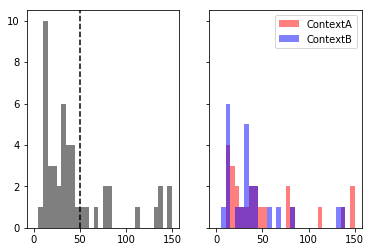

In [3]:
animal_id=[]
all_trials={'context':[],
           'duration':[]}
for unit in ensemble: 
    if unit.animal_id not in animal_id:
        animal_id.append(unit.animal_id)
        for ctx,dur in zip(unit.marker.protocol,unit.marker.door['duration']):
            all_trials['context'].append(ctx)
            all_trials['duration'].append(dur)
nbins=30
binrange=(0,150)
fig,ax=plt.subplots(1,2,sharey=True,sharex=True)
_=ax[0].hist(all_trials['duration'],nbins,binrange,color='k',alpha=0.5)
ax[0].axvline(x=50,color='k',linestyle='--')
_=ax[1].hist(np.extract(np.array(all_trials['context'])=='A',all_trials['duration']),nbins,binrange,color='red',alpha=0.5)
_=ax[1].hist(np.extract(np.array(all_trials['context'])=='B',all_trials['duration']),nbins,binrange,color='blue',alpha=0.5)
_=ax[1].legend(['ContextA','ContextB'])

## Aligned by door opening

parameters initialization

In [23]:
entrydur_range=[5,50]
####parameters initialization####
tbin=0.1 #firing rate average over tbin second window 
preevent=5
postevent=5
spkthreshold=20 #minimum spike count required
sigthreshold=1.65 #threshold for zscore response
dur_baseline=5

compute z-score response of units significantly activated after door opening in context A fast trials, and then compare it with response in context B fast trials 

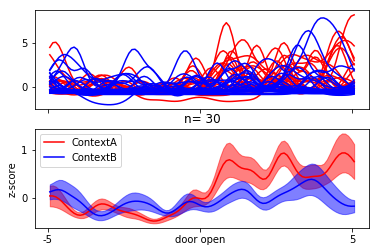

In [160]:
event_response={'A':{'sig':[]},
                'B':{'sig':[]},
               'preA':{'sig':[]},
               'postA':{'sig':[]},
               'preB':{'sig':[]},
               'postB':{'sig':[]}}
event_CDI=[]
for n,myUnit in enumerate(ensemble):
    #clean up unit marker, overwrite manual labeled event marker with auto detected ones
    trial=myUnit.split_trial()
    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    event=door_marker['open'] #aligned by door open 
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    preresponse={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    postresponse={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
    
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=3) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5 
                ifrpre=np.extract(ts>=event[num_trial]-preevent,ifr)[:int((preevent)/tbin)]
                ifrpost=np.extract(ts>=event[num_trial]-preevent,ifr)[int((preevent)/tbin)+1:int((preevent+postevent)/tbin)]
                try:
                    stat,pval=stats.mannwhitneyu(ifrpost,ifrpre,alternative='greater')
                    zfr=zscore(ifr) #zscore normalization 
                    z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                    fr_event=np.extract(ts>=event[num_trial]-preevent,ifr)[:int((preevent+postevent)/tbin)+1]
                    ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                    sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                    if (pval<=0.05) &  (np.max(z_event)<=20) & (ctx=='A'):
                        response_temp[ctx]['sig'].append(z_event)
                        preresponse[ctx]['sig'].append(np.mean(ifrpre))
                        postresponse[ctx]['sig'].append(np.mean(ifrpost))
                        #response_temp[ctx]['delay'].append(sig_t[0])
                    elif ctx=='B':
                        response_temp[ctx]['sig'].append(z_event)
                        preresponse[ctx]['sig'].append(np.mean(ifrpre))
                        postresponse[ctx]['sig'].append(np.mean(ifrpost))
    #                     try:
    #                         response_temp[ctx]['delay'].append(sig_t[0])
    #                     except:
    #                         response_temp[ctx]['delay'].append([])
                    else:
                        pass
                except:
                    pass
            
    if (np.size(response_temp['A']['sig'])>0) &(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
        event_response['preA']['sig'].append(preresponse['A']['sig'][0])
        event_response['preB']['sig'].append(preresponse['B']['sig'][0])
        event_response['postA']['sig'].append(postresponse['A']['sig'][0])
        event_response['postB']['sig'].append(postresponse['B']['sig'][0])
    else:
        pass
f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door open',postevent])
ax[1].set_ylabel('z-score')
plt.legend(['ContextA','ContextB'])


p = 0.000002
p = 0.035009


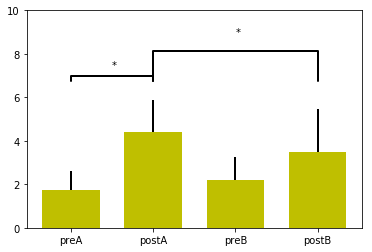

In [171]:
stat1,p1=stats.wilcoxon(event_response['preA']['sig'],event_response['postA']['sig'])
stat2,p2=stats.wilcoxon(event_response['preB']['sig'],event_response['postB']['sig'])
stat3,p3=stats.wilcoxon(event_response['preA']['sig'],event_response['preB']['sig'])
stat4,p4=stats.wilcoxon(event_response['postA']['sig'],event_response['postB']['sig'])


menMeans   = (np.mean(event_response['preA']['sig']), np.mean(event_response['postA']['sig']),
              np.mean(event_response['preB']['sig']), np.mean(event_response['postB']['sig']))
menStd     = (stats.sem(event_response['preA']['sig']), stats.sem(event_response['postA']['sig']),
              stats.sem(event_response['preB']['sig']), stats.sem(event_response['postB']['sig']))

ind  = np.arange(4)    # the x locations for the groups
width= 0.7
labels = ('preA', 'postA', 'preB', 'postB')

# Pull the formatting out here
bar_kwargs = {'width':width,'color':'y','linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k'}  #for matplotlib >= v1.4 use 'fmt':'none' instead

fig, ax = plt.subplots()
ax.p1 = plt.bar(ind, menMeans, **bar_kwargs)
ax.errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)


# Custom function to draw the diff bars

def label_diff(i,j,text,X,Y,height1,height2):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(x,y+height1+height2), zorder=10)
    ax.annotate('', xy=(X[i],y+height1), xytext=(X[j],y+height1), arrowprops=props)

# Call the function
if p1<0.05:
    label_diff(0,1,'*',ind,menMeans+menStd,1,1.5)
    print('p = %f'%p1)
if p2<0.05:
    label_diff(2,3,'*',ind,menMeans+menStd,1,1.5)
    print('p = %f'%p2)
if p3<0.05:
    label_diff(0,2,'*',ind,menMeans+menStd,6.5,8)
    print('p = %f'%p3)
if p4<0.05:
    label_diff(1,3,'*',ind,menMeans+menStd,1,3)
    print('p = %f'%p4)


plt.ylim(ymax=10)
plt.xticks(ind, labels, color='k')
plt.show()

[Text(0,0,'-5'), Text(0,0,'door open'), Text(0,0,'5')]

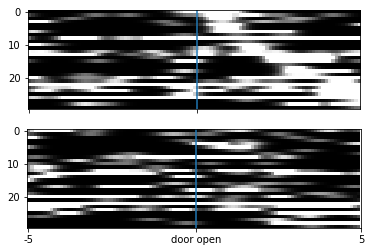

In [50]:
f,ax=plt.subplots(2,1,sharex=True)
sigra=np.array(event_response['A']['sig'])
sigrb=np.array(event_response['B']['sig'])
ind=np.argsort(np.argmax(sigra[:,int(preevent/tbin+1):-1], axis=1))
ind.tolist()
siga_sorted=[sigra[i] for i in ind]
sigb_sorted=[sigrb[i] for i in ind]
ax[0].imshow(siga_sorted,cmap='gray',vmin=0,vmax=3)
ax[0].axvline(x=int(preevent/tbin+1))
ax[1].imshow(sigb_sorted,cmap='gray',vmin=0,vmax=3)
ax[1].axvline(x=int(preevent/tbin+1))
ax[1].set_xticks([0,int(preevent/tbin+1),np.shape(sigra)[1]])
ax[1].set_xticklabels([-preevent,'door open',postevent])

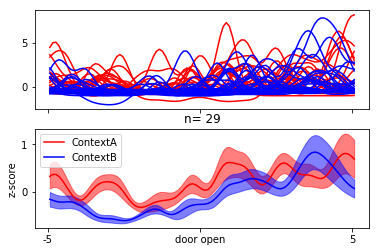

In [150]:
event_response={'A':{'sig':[]},
                'B':{'sig':[]},
               'preA':{'sig':[]},
               'postA':{'sig':[]},
               'preB':{'sig':[]},
               'postB':{'sig':[]}}
event_CDI=[]
for n,myUnit in enumerate(ensemble):
    #clean up unit marker, overwrite manual labeled event marker with auto detected ones
    trial=myUnit.split_trial()
    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    event=door_marker['open'] #aligned by door open 
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    preresponse={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    postresponse={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
    
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=3) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5 
                ifrpre=np.extract(ts>=event[num_trial]-preevent,ifr)[:int((preevent)/tbin)]
                ifrpost=np.extract(ts>=event[num_trial]-preevent,ifr)[int((preevent)/tbin)+1:int((preevent+postevent)/tbin)]
                try:
                    stat,pval=stats.mannwhitneyu(ifrpost,ifrpre,alternative='greater')
                    zfr=zscore(ifr) #zscore normalization 
                    z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                    fr_event=np.extract(ts>=event[num_trial]-preevent,ifr)[:int((preevent+postevent)/tbin)+1]
                    ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                    sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                    if (pval<=0.05) &  (np.max(z_event)<=20) & (ctx=='B'):
                        response_temp[ctx]['sig'].append(z_event)
                        preresponse[ctx]['sig'].append(np.mean(ifrpre))
                        postresponse[ctx]['sig'].append(np.mean(ifrpost))
                        #response_temp[ctx]['delay'].append(sig_t[0])
                    elif ctx=='A':
                        response_temp[ctx]['sig'].append(z_event)
                        preresponse[ctx]['sig'].append(np.mean(ifrpre))
                        postresponse[ctx]['sig'].append(np.mean(ifrpost))
    #                     try:
    #                         response_temp[ctx]['delay'].append(sig_t[0])
    #                     except:
    #                         response_temp[ctx]['delay'].append([])
                    else:
                        pass
                except:
                    pass
            
    if (np.size(response_temp['A']['sig'])>0) &(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
        event_response['preA']['sig'].append(preresponse['A']['sig'][0])
        event_response['preB']['sig'].append(preresponse['B']['sig'][0])
        event_response['postA']['sig'].append(postresponse['A']['sig'][0])
        event_response['postB']['sig'].append(postresponse['B']['sig'][0])
    else:
        pass
f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door open',postevent])
ax[1].set_ylabel('z-score')
plt.legend(['ContextA','ContextB'])


p = 0.010397
p = 0.000003
p = 0.017897


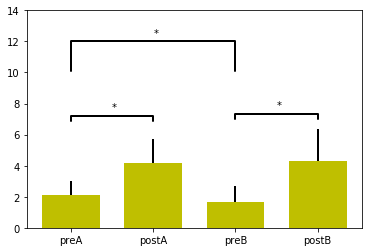

In [159]:
stat1,p1=stats.wilcoxon(event_response['preA']['sig'],event_response['postA']['sig'])
stat2,p2=stats.wilcoxon(event_response['preB']['sig'],event_response['postB']['sig'])
stat3,p3=stats.wilcoxon(event_response['preA']['sig'],event_response['preB']['sig'])
stat4,p4=stats.wilcoxon(event_response['postA']['sig'],event_response['postB']['sig'])


menMeans   = (np.mean(event_response['preA']['sig']), np.mean(event_response['postA']['sig']),
              np.mean(event_response['preB']['sig']), np.mean(event_response['postB']['sig']))
menStd     = (stats.sem(event_response['preA']['sig']), stats.sem(event_response['postA']['sig']),
              stats.sem(event_response['preB']['sig']), stats.sem(event_response['postB']['sig']))

ind  = np.arange(4)    # the x locations for the groups
width= 0.7
labels = ('preA', 'postA', 'preB', 'postB')

# Pull the formatting out here
bar_kwargs = {'width':width,'color':'y','linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k'}  #for matplotlib >= v1.4 use 'fmt':'none' instead

fig, ax = plt.subplots()
ax.p1 = plt.bar(ind, menMeans, **bar_kwargs)
ax.errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)


# Custom function to draw the diff bars

def label_diff(i,j,text,X,Y,height1,height2):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(x,y+height1+height2), zorder=10)
    ax.annotate('', xy=(X[i],y+height1), xytext=(X[j],y+height1), arrowprops=props)

# Call the function
if p1<0.05:
    label_diff(0,1,'*',ind,menMeans+menStd,1,2)
    print('p = %f'%p1)
if p2<0.05:
    label_diff(2,3,'*',ind,menMeans+menStd,1,2)
    print('p = %f'%p2)
if p3<0.05:
    label_diff(0,2,'*',ind,menMeans+menStd,6.5,3.5)
    print('p = %f'%p3)
if p4<0.05:
    label_diff(1,3,'*',ind,menMeans+menStd,1,2)
    print('p = %f'%p4)


plt.ylim(ymax=14)
plt.xticks(ind, labels, color='k')
plt.show()

[Text(0,0,'-5'), Text(0,0,'door open'), Text(0,0,'5')]

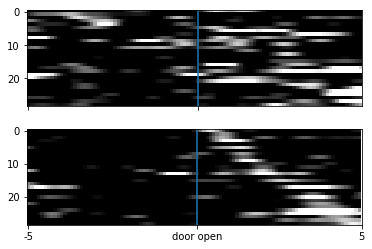

In [142]:
f,ax=plt.subplots(2,1,sharex=True)
sigra=np.array(event_response['A']['sig'])
sigrb=np.array(event_response['B']['sig'])
ind=np.argsort(np.argmax(sigrb[:,int(preevent/tbin+1):-1], axis=1))
ind.tolist()
siga_sorted=[sigra[i] for i in ind]
sigb_sorted=[sigrb[i] for i in ind]
ax[0].imshow(siga_sorted,cmap='gray',vmin=0,vmax=3)
ax[0].axvline(x=int(preevent/tbin+1))
ax[1].imshow(sigb_sorted,cmap='gray',vmin=0,vmax=3)
ax[1].axvline(x=int(preevent/tbin+1))
ax[1].set_xticks([0,int(preevent/tbin+1),np.shape(sigra)[1]])
ax[1].set_xticklabels([-preevent,'door open',postevent])

## Aligned by context entering 

In [135]:
entrydur_range=[0,50]
####parameters initialization####
tbin=0.1 #firing rate average over tbin second window 
preevent=5
postevent=5
spkthreshold=20 #minimum spike count required
sigthreshold=1.65 #threshold for zscore response

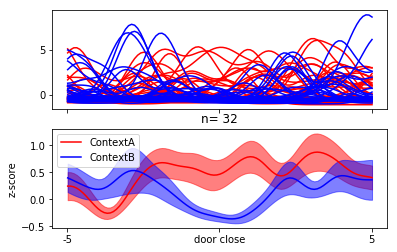

In [136]:
# Reference by cells that were significantly activated in context A 
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    trial=myUnit.split_trial()

    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    #event=door_marker['close']
    event=myUnit.marker.enter_context['ts']
    
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='A'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='B':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['A']['delay'])>0)&(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door close',postevent])
ax[1].set_ylabel('z-score')
plt.legend(['ContextA','ContextB'])

[Text(0,0,'-5'), Text(0,0,'enter context'), Text(0,0,'5')]

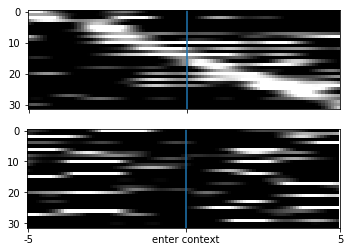

In [139]:
f,ax=plt.subplots(2,1,sharex=True)
sigra=np.array(event_response['A']['sig'])
sigrb=np.array(event_response['B']['sig'])
ind=np.argsort(np.argmax(sigra, axis=1))
ind.tolist()
siga_sorted=[sigra[i] for i in ind]
sigb_sorted=[sigrb[i] for i in ind]
ax[0].imshow(siga_sorted,cmap='gray',vmin=0,vmax=3)
ax[0].axvline(x=int(preevent/tbin+1))
ax[1].imshow(sigb_sorted,cmap='gray',vmin=0,vmax=3)
ax[1].axvline(x=int(preevent/tbin+1))
ax[1].set_xticks([0,int(preevent/tbin+1),np.shape(sigra)[1]])
ax[1].set_xticklabels([-preevent,'enter context',postevent])

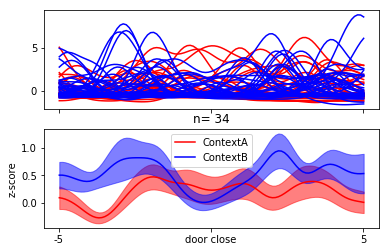

In [140]:
# Reference by cells that were significantly activated in context B
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    trial=myUnit.split_trial()

    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    #event=door_marker['close']
    event=myUnit.marker.enter_context['ts']
    
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='B'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='A':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['B']['delay'])>0)&(np.size(response_temp['A']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door close',postevent])
ax[1].set_ylabel('z-score')
plt.legend(['ContextA','ContextB'])

[Text(0,0,'-5'), Text(0,0,'enter context'), Text(0,0,'5')]

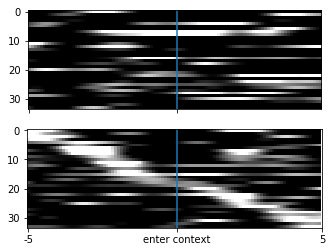

In [141]:
f,ax=plt.subplots(2,1,sharex=True)
sigra=np.array(event_response['A']['sig'])
sigrb=np.array(event_response['B']['sig'])
ind=np.argsort(np.argmax(sigrb, axis=1))
ind.tolist()
siga_sorted=[sigra[i] for i in ind]
sigb_sorted=[sigrb[i] for i in ind]
ax[0].imshow(siga_sorted,cmap='gray',vmin=0,vmax=3)
ax[0].axvline(x=int(preevent/tbin+1))
ax[1].imshow(sigb_sorted,cmap='gray',vmin=0,vmax=3)
ax[1].axvline(x=int(preevent/tbin+1))
ax[1].set_xticks([0,int(preevent/tbin+1),np.shape(sigra)[1]])
ax[1].set_xticklabels([-preevent,'enter context',postevent])

In [ ]:
#Next we calculate the statistics using firing rate between Context A and ContextB 


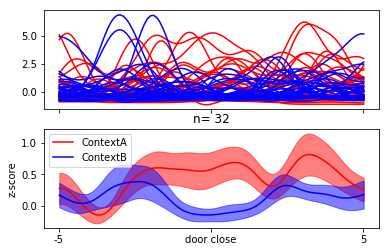

In [39]:
# Reference by cells that were significantly activated in context A 
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    trial=myUnit.split_trial()

    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    #event=door_marker['close']
    event=myUnit.marker.enter_context['ts']
    
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='A'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='B':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['A']['delay'])>0)&(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(np.mean(response_temp['A']['sig'],axis=0)) 
        event_response['B']['sig'].append(np.mean(response_temp['B']['sig'],axis=0)) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door close',postevent])
ax[1].set_ylabel('z-score')
plt.legend(['ContextA','ContextB'])